In [1]:
import matplotlib.pyplot as plt

from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

digits = datasets.load_digits()

In [2]:
n_samples = len(digits.images)
data_with_padding = np.pad(digits.images.reshape((n_samples, -1)), ((0, 0), (1, 1)), 'constant')

X_train, X_temp, y_train, y_temp = train_test_split(
    data_with_padding, digits.target, test_size=0.4, stratify=digits.target, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [3]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report

clf = Perceptron(tol=1e-3, random_state=42)
clf.fit(X_train, y_train)

y_val_pred = clf.predict(X_val)

print("Validation Performance:")
print(classification_report(y_val, y_val_pred))

y_test_pred = clf.predict(X_test)

print("Test Performance:")
print(classification_report(y_test, y_test_pred))


Validation Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.91      0.89      0.90        36
           2       1.00      0.92      0.96        36
           3       0.92      1.00      0.96        36
           4       0.95      0.97      0.96        36
           5       0.94      0.94      0.94        36
           6       0.92      1.00      0.96        36
           7       1.00      0.94      0.97        36
           8       0.94      0.89      0.91        35
           9       0.92      0.94      0.93        36

    accuracy                           0.95       359
   macro avg       0.95      0.95      0.95       359
weighted avg       0.95      0.95      0.95       359

Test Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.91      0.84      0.87        37
           2       1.00      0.97   

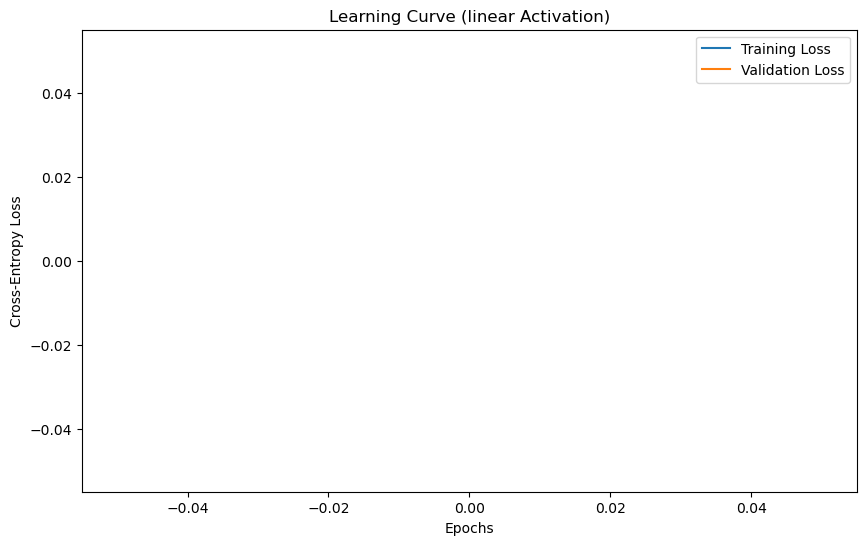

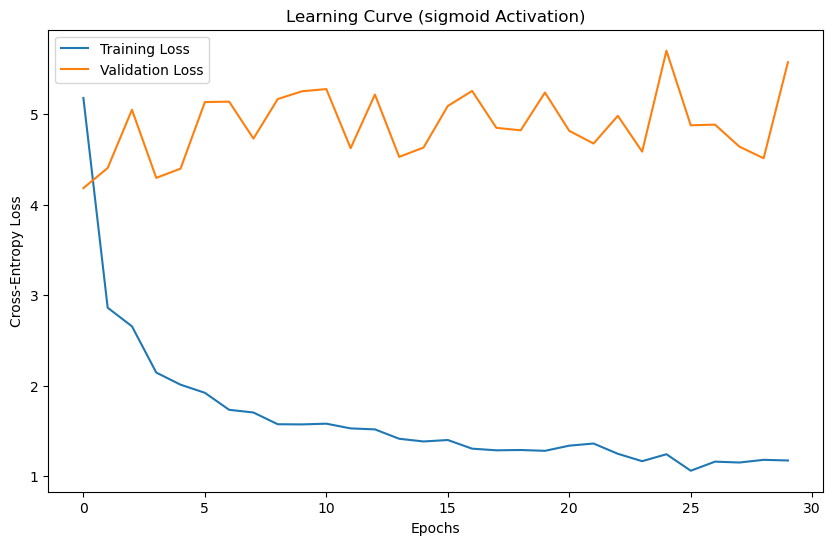

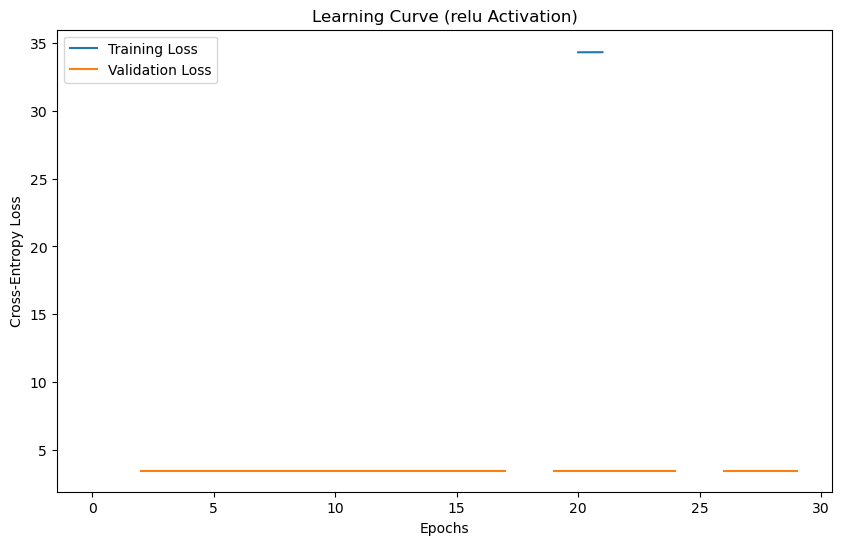

Linear Activation - Validation Accuracy: 0.10027855153203342, Test Accuracy: 0.09722222222222222
Sigmoid Activation - Validation Accuracy: 0.9303621169916435, Test Accuracy: 0.9277777777777778
Relu Activation - Validation Accuracy: 0.10027855153203342, Test Accuracy: 0.09722222222222222


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class CustomPerceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, activation_function='sigmoid', learning_rate=0.01, n_iterations=30):
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def _activation(self, x):
        if self.activation_function == 'linear':
            return x
        elif self.activation_function == 'sigmoid':
            return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)

    def _compute_loss(self, X, y, weights, bias):
        total_loss = 0
        for idx, x_i in enumerate(X):
            y_binary = np.where(y == self.classes_[0], 1, 0)
            linear_output = np.dot(x_i, weights) + bias
            y_predicted = self._activation(linear_output)
            total_loss -= y_binary[idx] * np.log(y_predicted + 1e-15) + (1 - y_binary[idx]) * np.log(1 - y_predicted + 1e-15)
        return total_loss / len(X)

    def fit(self, X, y, X_val=None, y_val=None):
        self.classes_ = np.unique(y)
        self.loss_ = []
        self.val_loss_ = []
        weights = {class_: np.zeros(X.shape[1]) for class_ in self.classes_}
        bias = {class_: 0 for class_ in self.classes_}

        for _ in range(self.n_iterations):
            total_loss = 0
            for class_ in self.classes_:
                y_binary = np.where(y == class_, 1, 0)

                for idx, x_i in enumerate(X):
                    linear_output = np.dot(x_i, weights[class_]) + bias[class_]
                    y_predicted = self._activation(linear_output)
                    update = self.learning_rate * (y_binary[idx] - y_predicted)
                    weights[class_] += update * x_i
                    bias[class_] += update

                    if y_binary[idx] == 1:
                        total_loss -= np.log(y_predicted + 1e-15)
                    else:
                        total_loss -= np.log(1 - y_predicted + 1e-15)

            self.loss_.append(total_loss / len(X))

            if X_val is not None and y_val is not None:
                val_loss = self._compute_loss(X_val, y_val, weights[class_], bias[class_])
                self.val_loss_.append(val_loss)

        self.classifiers = [(weights[class_], bias[class_]) for class_ in self.classes_]

    def predict(self, X):
        predictions = np.array([self._activation(np.dot(X, w) + b) for w, b in self.classifiers]).T
        return np.argmax(predictions, axis=1)

def train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train, X_val, y_val)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_, label='Training Loss')
    plt.plot(model.val_loss_, label='Validation Loss')
    plt.title(f'Learning Curve ({model.activation_function} Activation)')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.show()

    return val_accuracy, test_accuracy

activations = ['linear', 'sigmoid', 'relu']
results = {}
for act in activations:
    model = CustomPerceptron(activation_function=act)
    val_acc, test_acc = train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test)
    results[act] = (val_acc, test_acc)

for act, (val_acc, test_acc) in results.items():
    print(f"{act.capitalize()} Activation - Validation Accuracy: {val_acc}, Test Accuracy: {test_acc}")


Training with Linear Activation Function
Epoch 1/30 - Train Loss: nan - Validate Loss: nan
Epoch 2/30 - Train Loss: nan - Validate Loss: nan
Epoch 3/30 - Train Loss: nan - Validate Loss: nan
Epoch 4/30 - Train Loss: nan - Validate Loss: nan
Epoch 5/30 - Train Loss: nan - Validate Loss: nan
Epoch 6/30 - Train Loss: nan - Validate Loss: nan
Epoch 7/30 - Train Loss: nan - Validate Loss: nan
Epoch 8/30 - Train Loss: nan - Validate Loss: nan
Epoch 9/30 - Train Loss: nan - Validate Loss: nan
Epoch 10/30 - Train Loss: nan - Validate Loss: nan
Epoch 11/30 - Train Loss: nan - Validate Loss: nan
Epoch 12/30 - Train Loss: nan - Validate Loss: nan
Epoch 13/30 - Train Loss: nan - Validate Loss: nan
Epoch 14/30 - Train Loss: nan - Validate Loss: nan
Epoch 15/30 - Train Loss: nan - Validate Loss: nan
Epoch 16/30 - Train Loss: nan - Validate Loss: nan
Epoch 17/30 - Train Loss: nan - Validate Loss: nan
Epoch 18/30 - Train Loss: nan - Validate Loss: nan
Epoch 19/30 - Train Loss: nan - Validate Loss: nan

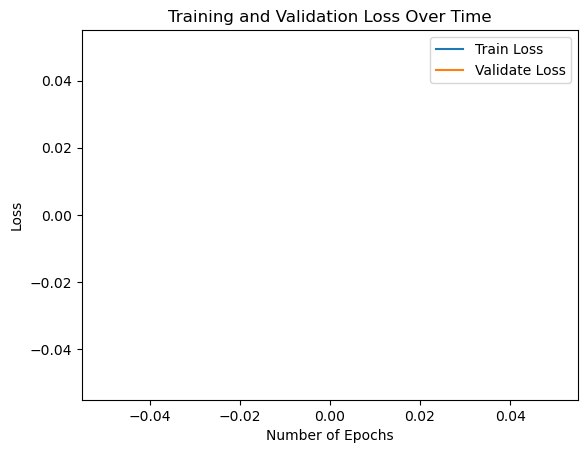

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       0.92      0.92      0.92        37
           2       0.91      0.91      0.91        35
           3       0.90      0.95      0.92        37
           4       0.97      0.89      0.93        36
           5       0.92      0.97      0.95        37
           6       0.95      1.00      0.97        36
           7       0.95      0.97      0.96        36
           8       0.89      0.71      0.79        35
           9       0.83      0.83      0.83        36

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.91       360
weighted avg       0.92      0.92      0.92       360

Confusion Matrix:
 [[35  0  0  0  0  0  0  0  0  0]
 [ 0 34  1  0  0  0  0  0  1  1]
 [ 1  1 32  1  0  0  0  0  0  0]
 [ 0  0  1 35  0  0  0  0  0  1]
 [ 0  0  0  0 32  0  0  2  0  2]
 [ 1  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  0 36  

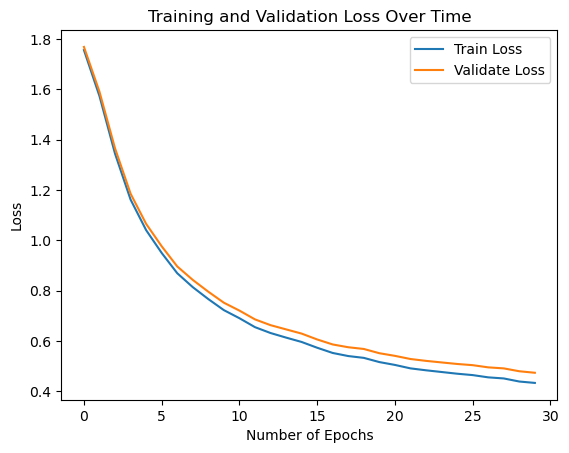

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       0.94      0.81      0.87        37
           2       0.92      0.97      0.94        35
           3       0.95      0.95      0.95        37
           4       1.00      0.86      0.93        36
           5       0.92      0.97      0.95        37
           6       1.00      0.97      0.99        36
           7       0.90      1.00      0.95        36
           8       0.87      0.77      0.82        35
           9       0.80      0.92      0.86        36

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360

Confusion Matrix:
 [[35  0  0  0  0  0  0  0  0  0]
 [ 0 30  2  0  0  0  0  0  1  4]
 [ 1  0 34  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  1  0  0  0  1]
 [ 0  0  0  0 31  0  0  3  2  0]
 [ 1  0  0  0  0 36  0  0  0  0]
 [ 0  1  0  0  0  0 35  

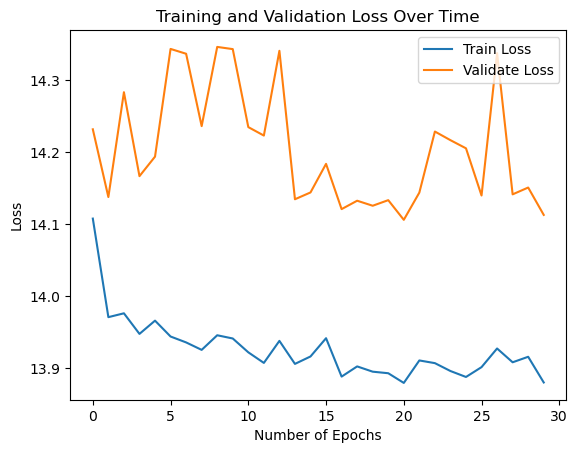

              precision    recall  f1-score   support

           0       0.23      0.54      0.33        35
           1       0.00      0.00      0.00        37
           2       0.69      1.00      0.81        35
           3       0.00      0.00      0.00        37
           4       0.79      0.92      0.85        36
           5       0.67      0.95      0.79        37
           6       0.80      1.00      0.89        36
           7       0.80      0.97      0.88        36
           8       0.00      0.00      0.00        35
           9       0.80      0.97      0.88        36

    accuracy                           0.63       360
   macro avg       0.48      0.63      0.54       360
weighted avg       0.48      0.63      0.54       360

Confusion Matrix:
 [[19  0  0  1  5  5  3  1  0  1]
 [16  0  6  0  3  2  1  5  0  4]
 [ 0  0 35  0  0  0  0  0  0  0]
 [21  0  7  0  0  7  1  0  0  1]
 [ 0  0  0  0 33  0  0  1  0  2]
 [ 0  0  1  0  0 35  0  1  0  0]
 [ 0  0  0  0  0  0 36  

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

digits_data = load_digits()
features, targets = digits_data.data, digits_data.target
features /= 16.0
features_extended = np.pad(features, ((0, 0), (1, 1)), 'constant')
X_train_full, X_test_temp, y_train_full, y_test_temp = train_test_split(features_extended, targets, test_size=0.4, stratify=targets)
X_validate, X_evaluate, y_validate, y_evaluate = train_test_split(X_test_temp, y_test_temp, test_size=0.5, stratify=y_test_temp)

def activate_linear(input_val):
    return input_val

def derivative_linear(input_val):
    return np.ones_like(input_val)

def activate_sigmoid(input_val):
    return 1 / (1 + np.exp(-input_val))

def derivative_sigmoid(input_val):
    activated = activate_sigmoid(input_val)
    return activated * (1 - activated)

def activate_relu(input_val):
    return np.maximum(0, input_val)

def derivative_relu(input_val):
    return (input_val > 0).astype(float)

class Perceptron:
    def __init__(self, input_size, activation, derivative):
        self.w = np.random.normal(0, 0.01, (input_size, 10))
        self.b = np.zeros(10)
        self.activate = activation
        self.derivative = derivative

    def forward_pass(self, inputs):
        self.inputs = inputs
        self.pre_activation = np.dot(inputs, self.w) + self.b
        return self.activate(self.pre_activation)

    def backward_pass(self, pred, true):
        n_samples = true.shape[0]
        true_one_hot = np.eye(10)[true]
        diff = pred - true_one_hot
        pre_activation_derivative = self.derivative(self.pre_activation)
        grad_w = np.dot(self.inputs.T, diff * pre_activation_derivative) / n_samples
        grad_b = np.sum(diff * pre_activation_derivative, axis=0) / n_samples
        return grad_w, grad_b

    def apply_gradients(self, grad_w, grad_b, eta):
        self.w -= eta * grad_w
        self.b -= eta * grad_b

def train_network(network, X_train, y_train, X_validate, y_validate, num_epochs, eta):
    metrics = {'train_loss': [], 'validate_loss': []}
    for epoch in range(num_epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]

        for i in range(X_train.shape[0]):
            instance_features, instance_target = X_train_shuffled[i:i+1], y_train_shuffled[i:i+1]
            predictions = network.forward_pass(instance_features)
            grad_w, grad_b = network.backward_pass(predictions, instance_target)
            network.apply_gradients(grad_w, grad_b, eta)

        training_loss = compute_loss(network.forward_pass(X_train), y_train)
        validation_loss = compute_loss(network.forward_pass(X_validate), y_validate)
        metrics['train_loss'].append(training_loss)
        metrics['validate_loss'].append(validation_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {training_loss:.4f} - Validate Loss: {validation_loss:.4f}")

    return metrics

def compute_loss(predictions, targets):
    n_samples = targets.shape[0]
    targets_one_hot = np.eye(10)[targets]
    return -np.sum(targets_one_hot * np.log(predictions + 1e-15)) / n_samples

def display_learning_curves(metrics):
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['validate_loss'], label='Validate Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(network, X_train, y_train, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs, eta):
    training_metrics = train_network(network, X_train, y_train, X_validate, y_validate, num_epochs, eta)
    display_learning_curves(training_metrics)

    predictions = np.argmax(network.forward_pass(X_evaluate), axis=1)
    print(classification_report(y_evaluate, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_evaluate, predictions))

print("Training with Linear Activation Function")
network_linear = Perceptron(input_size=66, activation=activate_linear, derivative=derivative_linear)
evaluate_model(network_linear, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs=30, eta=0.01)

print("\nTraining with Sigmoid Activation Function")
network_sigmoid = Perceptron(input_size=66, activation=activate_sigmoid, derivative=derivative_sigmoid)
evaluate_model(network_sigmoid, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs=30, eta=0.01)

print("\nTraining with ReLU Activation Function")
network_relu = Perceptron(input_size=66, activation=activate_relu, derivative=derivative_relu)
evaluate_model(network_relu, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs=30, eta=0.01)


Training with Linear Activation Function
Epoch 1/30 - Train Loss: 2.7171 - Validate Loss: 2.7174
Epoch 2/30 - Train Loss: 2.4248 - Validate Loss: 2.4250
Epoch 3/30 - Train Loss: 2.3426 - Validate Loss: 2.3426
Epoch 4/30 - Train Loss: 2.3159 - Validate Loss: 2.3160
Epoch 5/30 - Train Loss: 2.3071 - Validate Loss: 2.3073
Epoch 6/30 - Train Loss: 2.3041 - Validate Loss: 2.3042
Epoch 7/30 - Train Loss: 2.3032 - Validate Loss: 2.3035
Epoch 8/30 - Train Loss: 2.3028 - Validate Loss: 2.3030
Epoch 9/30 - Train Loss: 2.3026 - Validate Loss: 2.3028
Epoch 10/30 - Train Loss: 2.3027 - Validate Loss: 2.3029
Epoch 11/30 - Train Loss: 2.3027 - Validate Loss: 2.3028
Epoch 12/30 - Train Loss: 2.3027 - Validate Loss: 2.3028
Epoch 13/30 - Train Loss: 2.3028 - Validate Loss: 2.3028
Epoch 14/30 - Train Loss: 2.3025 - Validate Loss: 2.3026
Epoch 15/30 - Train Loss: 2.3026 - Validate Loss: 2.3027
Epoch 16/30 - Train Loss: 2.3027 - Validate Loss: 2.3030
Epoch 17/30 - Train Loss: 2.3026 - Validate Loss: 2.3028

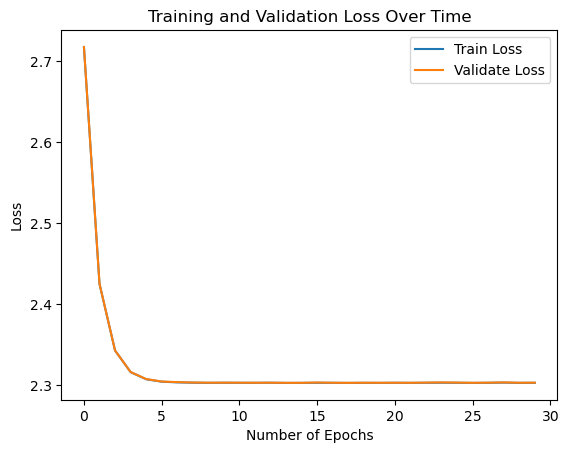

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        35
           3       0.10      1.00      0.19        37
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        36
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00        36

    accuracy                           0.10       360
   macro avg       0.01      0.10      0.02       360
weighted avg       0.01      0.10      0.02       360

Confusion Matrix:
 [[ 0  0  0 35  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  

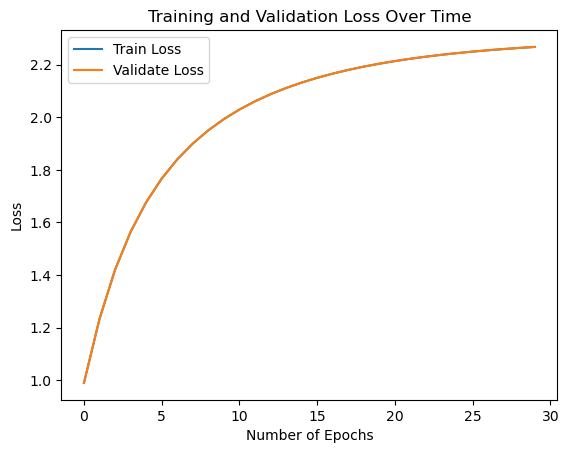

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00        35
           3       0.10      1.00      0.19        37
           4       0.00      0.00      0.00        36
           5       0.00      0.00      0.00        37
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        36
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00        36

    accuracy                           0.10       360
   macro avg       0.01      0.10      0.02       360
weighted avg       0.01      0.10      0.02       360

Confusion Matrix:
 [[ 0  0  0 35  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  

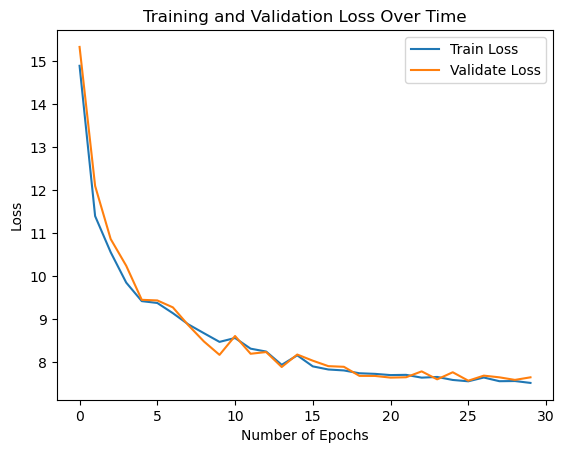

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        35
           1       0.86      1.00      0.92        37
           2       1.00      0.91      0.96        35
           3       0.74      0.86      0.80        37
           4       0.97      0.97      0.97        36
           5       0.00      0.00      0.00        37
           6       0.89      0.94      0.92        36
           7       0.92      1.00      0.96        36
           8       0.70      0.86      0.77        35
           9       0.69      0.97      0.80        36

    accuracy                           0.84       360
   macro avg       0.76      0.84      0.80       360
weighted avg       0.76      0.84      0.79       360

Confusion Matrix:
 [[30  0  0  1  0  0  3  0  1  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 32  1  0  0  0  0  2  0]
 [ 0  0  0 32  0  0  0  2  2  1]
 [ 0  0  0  0 35  0  0  0  1  0]
 [ 5  2  0  8  1  0  0  1  7 13]
 [ 0  2  0  0  0  0 34  

In [6]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

digits_data = load_digits()
features, targets = digits_data.data, digits_data.target
features /= 16.0 
X_train_full, X_test_temp, y_train_full, y_test_temp = train_test_split(features, targets, test_size=0.4, stratify=targets)
X_validate, X_evaluate, y_validate, y_evaluate = train_test_split(X_test_temp, y_test_temp, test_size=0.5, stratify=y_test_temp)

def activate_linear(input_val):
    return input_val

def derivative_linear(input_val):
    return np.ones_like(input_val)

def activate_sigmoid(input_val):
    return 1 / (1 + np.exp(-input_val))

def derivative_sigmoid(input_val):
    return activate_sigmoid(input_val) * (1 - activate_sigmoid(input_val))

def activate_relu(input_val):
    return np.maximum(0, input_val)

def derivative_relu(input_val):
    return (input_val > 0).astype(float)

def initialize_weights(size, activation_function):
    if activation_function == activate_relu:
        return np.random.randn(size[0], size[1]) * np.sqrt(2. / size[0])
    else:
        return np.random.randn(size[0], size[1]) * 0.01

class NeuralNetwork:
    def __init__(self, layer_sizes, activations, derivatives):
        self.layers = len(layer_sizes)
        self.weights = [initialize_weights((layer_sizes[i], layer_sizes[i+1]), activations[i]) for i in range(self.layers-1)]
        self.biases = [np.zeros(layer_sizes[i+1]) for i in range(self.layers-1)]
        self.activations = activations
        self.derivatives = derivatives

    def forward_pass(self, inputs):
        activation = inputs
        self.pre_activations = []
        self.activations_list = [activation]
        for i in range(self.layers-1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            self.pre_activations.append(z)
            activation = self.activations[i](z)
            self.activations_list.append(activation)
        return activation

    def backward_pass(self, pred, true, eta):
        n_samples = true.shape[0]
        true_one_hot = np.eye(10)[true]
        dA = pred - true_one_hot
        for i in reversed(range(self.layers-1)):
            dZ = dA * self.derivatives[i](self.pre_activations[i])
            dW = np.dot(self.activations_list[i].T, dZ) / n_samples
            dB = np.sum(dZ, axis=0) / n_samples
            dA = np.dot(dZ, self.weights[i].T)
            self.weights[i] -= eta * dW
            self.biases[i] -= eta * dB

def compute_loss(predictions, targets):
    n_samples = targets.shape[0]
    targets_one_hot = np.eye(10)[targets]
    return -np.sum(targets_one_hot * np.log(predictions + 1e-15)) / n_samples

def train_network(network, X_train, y_train, X_validate, y_validate, num_epochs, eta):
    metrics = {'train_loss': [], 'validate_loss': []}
    for epoch in range(num_epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]

        for i in range(X_train.shape[0]):
            instance_features, instance_target = X_train_shuffled[i:i+1], y_train_shuffled[i:i+1]
            predictions = network.forward_pass(instance_features)
            network.backward_pass(predictions, instance_target, eta)

        training_loss = compute_loss(network.forward_pass(X_train), y_train)
        validation_loss = compute_loss(network.forward_pass(X_validate), y_validate)
        metrics['train_loss'].append(training_loss)
        metrics['validate_loss'].append(validation_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {training_loss:.4f} - Validate Loss: {validation_loss:.4f}")

    return metrics

def display_learning_curves(metrics):
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['validate_loss'], label='Validate Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(network, X_train, y_train, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs, eta):
    training_metrics = train_network(network, X_train, y_train, X_validate, y_validate, num_epochs, eta)
    display_learning_curves(training_metrics)

    predictions = np.argmax(network.forward_pass(X_evaluate), axis=1)
    print(classification_report(y_evaluate, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_evaluate, predictions))

layer_sizes = [64, 50, 30, 20, 10]  
learning_rate = 0.001 

print("Training with Linear Activation Function")
activations_linear = [activate_linear] * 4
derivatives_linear = [derivative_linear] * 4
network_linear = NeuralNetwork(layer_sizes, activations_linear, derivatives_linear)
evaluate_model(network_linear, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs=30, eta=learning_rate)

print("\nTraining with Sigmoid Activation Function")
activations_sigmoid = [activate_sigmoid] * 4
derivatives_sigmoid = [derivative_sigmoid] * 4
network_sigmoid = NeuralNetwork(layer_sizes, activations_sigmoid, derivatives_sigmoid)
evaluate_model(network_sigmoid, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs=30, eta=learning_rate)

print("\nTraining with ReLU Activation Function")
activations_relu = [activate_relu] * 4
derivatives_relu = [derivative_relu] * 4
network_relu = NeuralNetwork(layer_sizes, activations_relu, derivatives_relu)
evaluate_model(network_relu, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs=30, eta=learning_rate)


Training with Linear Activation Function
Epoch 1/30 - Train Loss: 2.6272 - Validate Loss: 2.6314
Epoch 2/30 - Train Loss: 2.3497 - Validate Loss: 2.3532
Epoch 3/30 - Train Loss: 2.2653 - Validate Loss: 2.2672
Epoch 4/30 - Train Loss: 2.2280 - Validate Loss: 2.2336
Epoch 5/30 - Train Loss: 2.2039 - Validate Loss: 2.2101
Epoch 6/30 - Train Loss: 2.1849 - Validate Loss: 2.1885
Epoch 7/30 - Train Loss: 2.1666 - Validate Loss: 2.1662
Epoch 8/30 - Train Loss: 2.1494 - Validate Loss: 2.1524
Epoch 9/30 - Train Loss: 2.1336 - Validate Loss: 2.1368
Epoch 10/30 - Train Loss: 2.1182 - Validate Loss: 2.1175
Epoch 11/30 - Train Loss: 2.1027 - Validate Loss: 2.1026
Epoch 12/30 - Train Loss: 2.0882 - Validate Loss: 2.0880
Epoch 13/30 - Train Loss: 2.0728 - Validate Loss: 2.0747
Epoch 14/30 - Train Loss: 2.0595 - Validate Loss: 2.0618
Epoch 15/30 - Train Loss: 2.0459 - Validate Loss: 2.0470
Epoch 16/30 - Train Loss: 2.0329 - Validate Loss: 2.0308
Epoch 17/30 - Train Loss: 2.0186 - Validate Loss: 2.0167

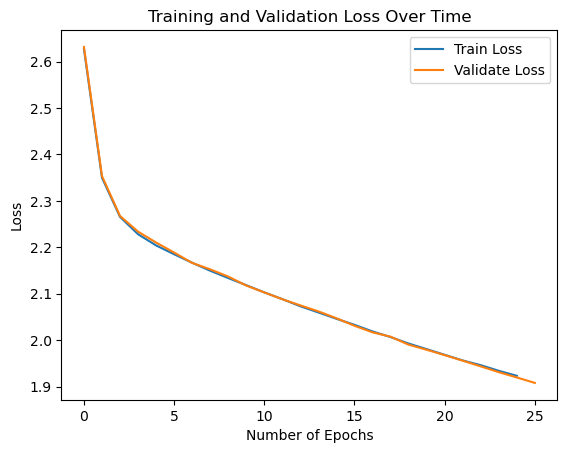

              precision    recall  f1-score   support

           0       0.58      0.97      0.73        38
           1       0.46      0.26      0.33        42
           2       0.57      0.95      0.71        40
           3       0.86      0.69      0.76        35
           4       0.84      0.69      0.76        39
           5       0.95      0.56      0.71        32
           6       0.72      0.91      0.81        34
           7       0.65      0.75      0.70        32
           8       0.90      0.47      0.62        38
           9       0.54      0.47      0.50        30

    accuracy                           0.67       360
   macro avg       0.71      0.67      0.66       360
weighted avg       0.70      0.67      0.66       360

Confusion Matrix:
 [[37  0  0  0  0  0  1  0  0  0]
 [ 2 11 15  0  1  0  1  3  2  7]
 [ 0  0 38  0  1  0  1  0  0  0]
 [ 0  4  1 24  0  0  3  3  0  0]
 [ 6  1  0  0 27  0  3  2  0  0]
 [ 4  0  3  0  0 18  2  0  0  5]
 [ 3  0  0  0  0  0 31  

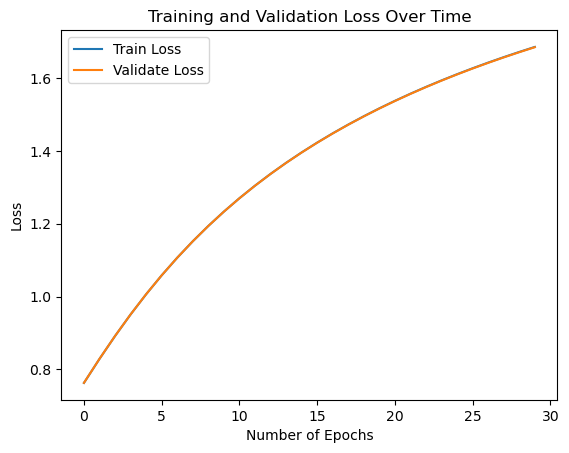

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        38
           1       0.35      0.71      0.47        42
           2       0.82      0.82      0.82        40
           3       0.48      0.83      0.61        35
           4       1.00      0.28      0.44        39
           5       0.00      0.00      0.00        32
           6       0.31      0.97      0.47        34
           7       0.86      0.56      0.68        32
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        30

    accuracy                           0.51       360
   macro avg       0.46      0.50      0.43       360
weighted avg       0.48      0.51      0.44       360

Confusion Matrix:
 [[30  3  0  1  0  0  4  0  0  0]
 [ 1 30  1  0  0  0  9  1  0  0]
 [ 0  2 33  3  0  0  2  0  0  0]
 [ 0  2  1 29  0  0  3  0  0  0]
 [ 0  9  0  0 11  0 18  1  0  0]
 [ 1  1  2  5  0  0 23  0  0  0]
 [ 0  1  0  0  0  0 33  

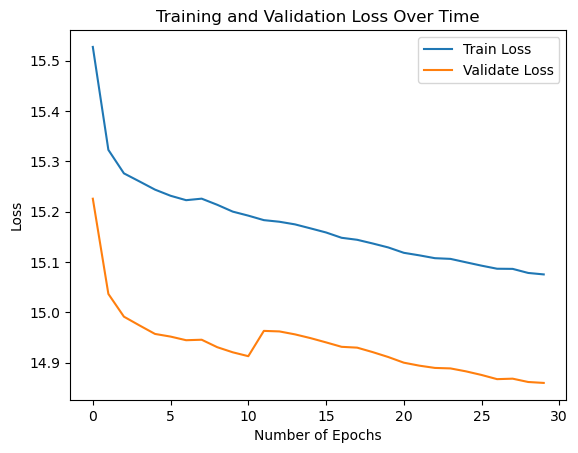

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.29      0.76      0.42        42
           2       0.33      0.75      0.46        40
           3       0.51      0.91      0.65        35
           4       0.00      0.00      0.00        39
           5       0.56      0.16      0.24        32
           6       0.00      0.00      0.00        34
           7       0.00      0.00      0.00        32
           8       0.30      0.32      0.31        38
           9       0.39      0.63      0.48        30

    accuracy                           0.36       360
   macro avg       0.24      0.35      0.26       360
weighted avg       0.23      0.36      0.26       360

Confusion Matrix:
 [[ 0  1 15  0  0  2  0  0  7 13]
 [ 0 32  3  4  0  0  0  0  1  2]
 [ 0  2 30  8  0  0  0  0  0  0]
 [ 0  0  3 32  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  3  0]
 [ 0  1 12  1  0  5  0  0  1 12]
 [ 0  6 11  0  0  2  0  

In [7]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

digits_data = load_digits()
features, targets = digits_data.data, digits_data.target
features /= 16.0
X_train_full, X_test_temp, y_train_full, y_test_temp = train_test_split(features, targets, test_size=0.4, random_state=42)
X_validate, X_evaluate, y_validate, y_evaluate = train_test_split(X_test_temp, y_test_temp, test_size=0.5, random_state=42)

def activate_linear(input_val):
    return input_val

def derivative_linear(input_val):
    return np.ones_like(input_val)

def activate_sigmoid(input_val):
    return 1 / (1 + np.exp(-input_val))

def derivative_sigmoid(input_val):
    return activate_sigmoid(input_val) * (1 - activate_sigmoid(input_val))

def activate_relu(input_val):
    return np.maximum(0, input_val)

def derivative_relu(input_val):
    return (input_val > 0).astype(float)

class ConvolutionalLayer:
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.1
        self.biases = np.zeros(out_channels)

    def forward(self, input):
        batch_size, in_channels, height, width = input.shape
        out_height = (height - self.kernel_size) // self.stride + 1
        out_width = (width - self.kernel_size) // self.stride + 1
        output = np.zeros((batch_size, self.out_channels, out_height, out_width))

        for i in range(out_height):
            for j in range(out_width):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                w_start = j * self.stride
                w_end = w_start + self.kernel_size
                region = input[:, :, h_start:h_end, w_start:w_end]
                for k in range(self.out_channels):
                    output[:, k, i, j] = np.sum(region * self.weights[k], axis=(1, 2, 3)) + self.biases[k]

        return output

class NeuralUnit:
    def __init__(self, input_size, output_size, activation, derivative):
        self.w = np.random.normal(0, 0.01, (input_size, output_size))
        self.b = np.zeros(output_size)
        self.activate = activation
        self.derivative = derivative

    def forward_pass(self, inputs):
        self.inputs = inputs
        self.pre_activation = np.dot(inputs, self.w) + self.b
        return self.activate(self.pre_activation)

    def backward_pass(self, pred, true):
        n_samples = true.shape[0]
        true_one_hot = np.eye(10)[true]
        diff = pred - true_one_hot
        pre_activation_derivative = self.derivative(self.pre_activation)
        grad_w = np.dot(self.inputs.T, diff * pre_activation_derivative) / n_samples
        grad_b = np.sum(diff * pre_activation_derivative, axis=0) / n_samples
        return grad_w, grad_b

    def apply_gradients(self, grad_w, grad_b, eta):
        self.w -= eta * grad_w
        self.b -= eta * grad_b

class SimpleCNN:
    def __init__(self, activation, derivative):
        self.conv1 = ConvolutionalLayer(in_channels=1, out_channels=3, kernel_size=4, stride=1)
        self.conv2 = ConvolutionalLayer(in_channels=3, out_channels=9, kernel_size=3, stride=1)
        self.fc_input_size = self.calculate_fc_input_size(8, 8)
        self.fc = NeuralUnit(input_size=self.fc_input_size, output_size=10, activation=activation, derivative=derivative)

    def calculate_fc_input_size(self, img_height, img_width):
        conv1_output_size = (img_height - self.conv1.kernel_size) // self.conv1.stride + 1
        conv2_output_size = (conv1_output_size - self.conv2.kernel_size) // self.conv2.stride + 1
        return conv2_output_size * conv2_output_size * self.conv2.out_channels

    def forward_pass(self, X):
        X = X.reshape(X.shape[0], 1, 8, 8)
        X = self.conv1.forward(X)
        X = activate_relu(X)
        X = self.conv2.forward(X)
        X = activate_relu(X)
        X = X.reshape(X.shape[0], -1)
        return self.fc.forward_pass(X)

    def backward_pass(self, pred, true, eta):
        grad_w, grad_b = self.fc.backward_pass(pred, true)
        self.fc.apply_gradients(grad_w, grad_b, eta)

def compute_loss(predictions, targets):
    n_samples = targets.shape[0]
    targets_one_hot = np.eye(10)[targets]
    return -np.sum(targets_one_hot * np.log(predictions + 1e-15)) / n_samples

def train_network(network, X_train, y_train, X_validate, y_validate, num_epochs, eta):
    metrics = {'train_loss': [], 'validate_loss': []}
    for epoch in range(num_epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_train_shuffled, y_train_shuffled = X_train[indices], y_train[indices]
        for i in range(X_train.shape[0]):
            instance_features, instance_target = X_train_shuffled[i:i+1], y_train_shuffled[i:i+1]
            predictions = network.forward_pass(instance_features)
            network.backward_pass(predictions, instance_target, eta)
        training_loss = compute_loss(network.forward_pass(X_train), y_train)
        validation_loss = compute_loss(network.forward_pass(X_validate), y_validate)
        metrics['train_loss'].append(training_loss)
        metrics['validate_loss'].append(validation_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {training_loss:.4f} - Validate Loss: {validation_loss:.4f}")
    return metrics

def display_learning_curves(metrics):
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['validate_loss'], label='Validate Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluate_model(network, X_train, y_train, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs, eta):
    training_metrics = train_network(network, X_train, y_train, X_validate, y_validate, num_epochs, eta)
    display_learning_curves(training_metrics)
    predictions = np.argmax(network.forward_pass(X_evaluate), axis=1)
    print(classification_report(y_evaluate, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_evaluate, predictions))

learning_rate = 0.001
num_epochs = 30

print("Training with Linear Activation Function")
network_linear = SimpleCNN(activate_linear, derivative_linear)
evaluate_model(network_linear, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs, learning_rate)

print("\nTraining with Sigmoid Activation Function")
network_sigmoid = SimpleCNN(activate_sigmoid, derivative_sigmoid)
evaluate_model(network_sigmoid, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs, learning_rate)

print("\nTraining with ReLU Activation Function")
network_relu = SimpleCNN(activate_relu, derivative_relu)
evaluate_model(network_relu, X_train_full, y_train_full, X_validate, y_validate, X_evaluate, y_evaluate, num_epochs, learning_rate)
